In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

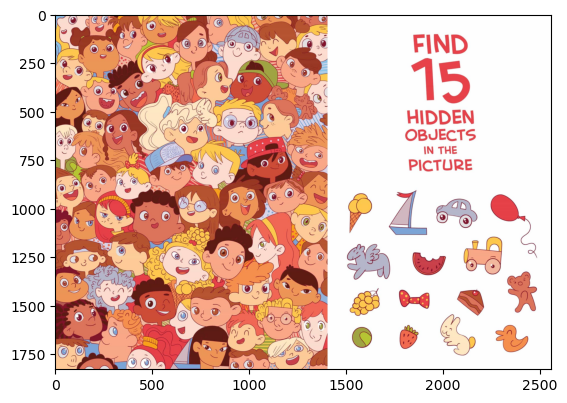

In [3]:
image = cv2.imread("Finding/1.jpg")
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

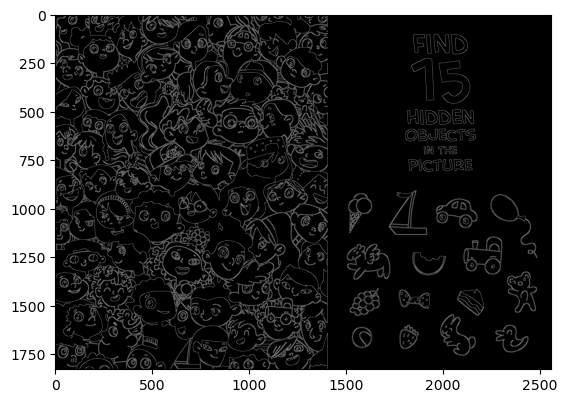

In [4]:
img_gaussian = cv2.GaussianBlur(gray_img, (5, 5), 0)
img_edge_det = cv2.Canny(img_gaussian, 100, 200)
plt.imshow(img_edge_det, cmap='gray')

In [5]:
lines = cv2.HoughLinesP(img_edge_det, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)

In [6]:
def is_collinear_and_perpendicular_to_horizontal_axis(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    if x1 == x2 and x2 == x3 and x3 == x4:
        if y1 == y3 and y2 == y4:
            return False
        return True
    return False

In [7]:
def detect_crop_lines(lines):
    for i in range(0, len(lines)):
        cropped_line = lines[i][0]
        for j in range(i + 1, len(lines)):
            if is_collinear_and_perpendicular_to_horizontal_axis(cropped_line,
                                                                lines[j][0]):
                print(cropped_line, lines[j][0])
                return cropped_line, lines[j][0]
    return None, None

In [8]:
cropped_line, line = detect_crop_lines(lines)
print(cropped_line)


[1406 1591 1406 1170] [1406  782 1406  593]
[1406 1591 1406 1170]


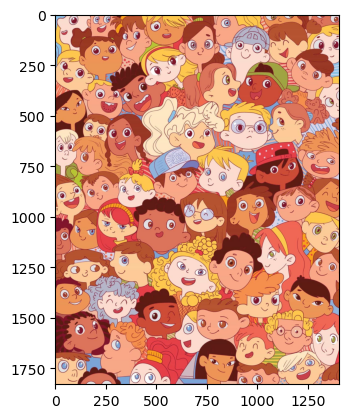

In [9]:
crop_img = image[:, :cropped_line[0]]
plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))

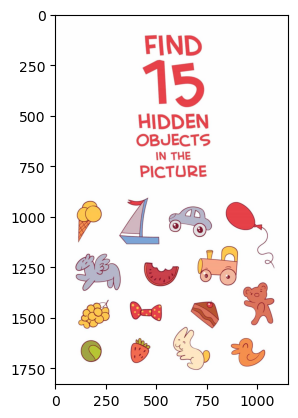

In [10]:
object_img = image[:, cropped_line[0]:]
plt.imshow(cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB))

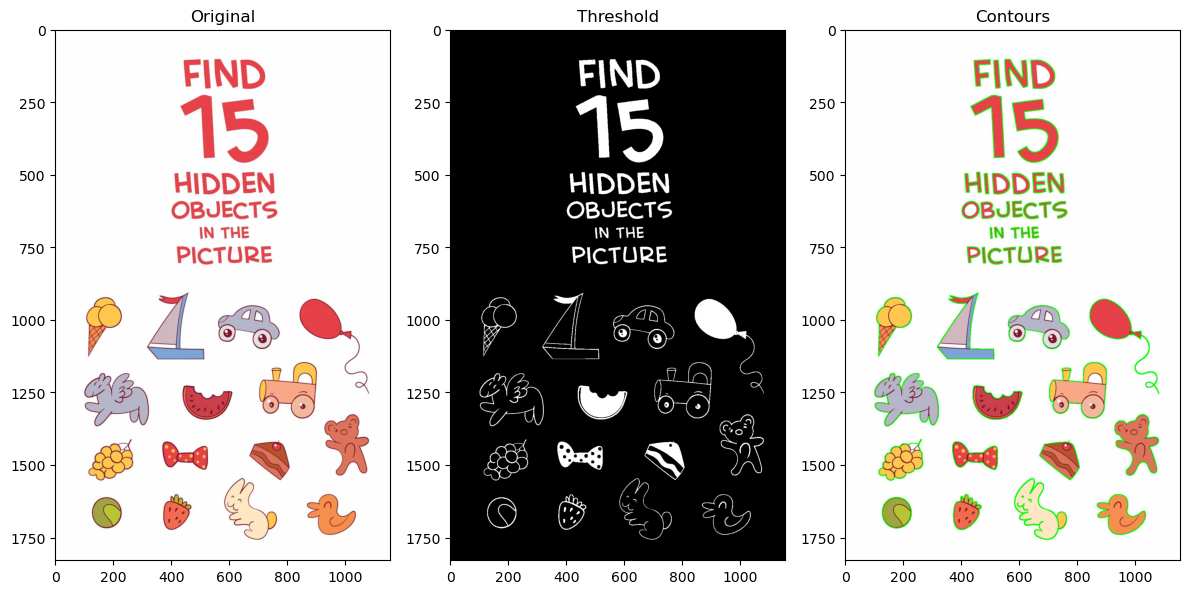

In [11]:
gray = cv2.cvtColor(object_img, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = object_img.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

objects = []
for i, contour in enumerate(contours):
    if cv2.contourArea(contour) > 100:
        x, y, w, h = cv2.boundingRect(contour)
        object_roi = object_img[y:y+h, x:x+w]
        objects.append(object_roi)
        
        cv2.imwrite(f'objects/object_{i}.jpg', object_roi)

plt.figure(figsize=(12, 8))
plt.subplot(131), plt.imshow(cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(132), plt.imshow(thresh, cmap='gray'), plt.title('Threshold')
plt.subplot(133), plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)), plt.title('Contours')
plt.tight_layout()
plt.show()

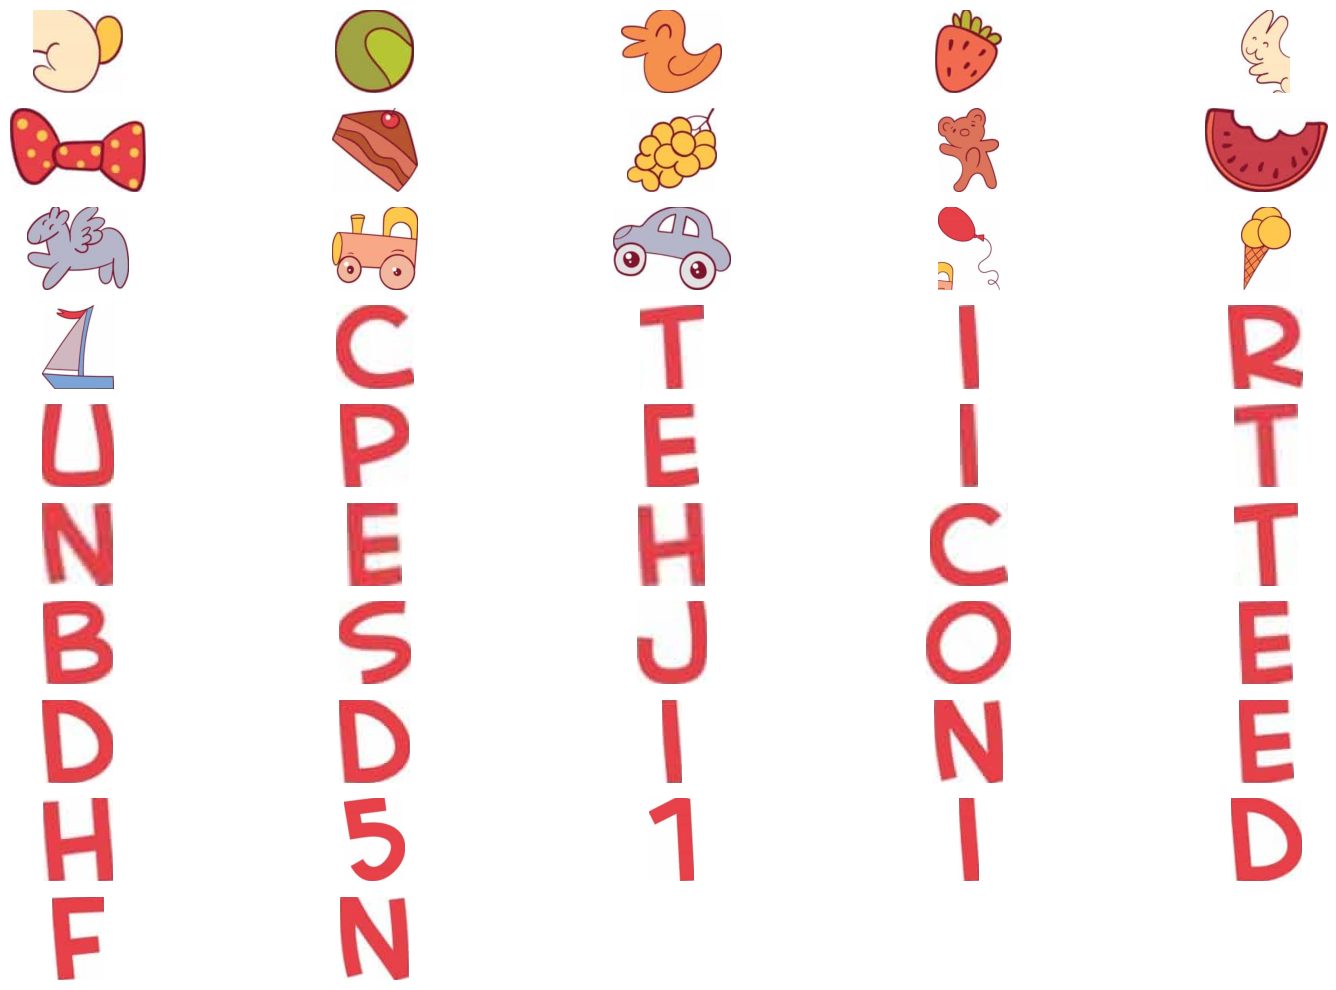

In [12]:
fig = plt.figure(figsize=(15, 10))
columns = 5
rows = (len(objects) + columns - 1) // columns
for i, object_img in enumerate(objects):
    if i < columns * rows:
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.tight_layout()
plt.show()

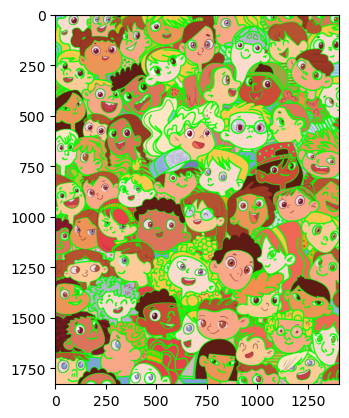

In [13]:
gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

crop_img_contours = crop_img.copy()
cv2.drawContours(crop_img_contours, contours, -1, (0, 255, 0), 2)


plt.imshow(cv2.cvtColor(crop_img_contours, cv2.COLOR_BGR2RGB))

In [14]:
match_objects_by_contours(objects_folder="objects", main_image=crop_img, output_path="result.jpg")

NameError: name 'match_objects_by_contours' is not defined